In [1]:
import cv2, os, math, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw

2024-03-01 11:10:06.718748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 11:10:06.718870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 11:10:06.871294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
characters = " !\"#%&'()*+,-./0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" # +"ĂÂÎȘȚăâîșț"
dataset_path = "/kaggle/input/flex-iam-full/IAM_full"

IMG_SIZE = (512,512)
SEQ_LEN = 1024
np.random.seed(2024)

In [3]:
"""
Converts a string to an array of labels.
Each character is mapped to an integer label that marks its 
position in the `characters` string.
The resulted array is padded up to `SEQ_LEN` with a constant 
value (has the same value with the so-called "CTC blank label").
"""
def text_to_labels(text:str):
    char_ids = []
    for c in text:
        cid = characters.find(c)
        if cid<0:
            print(f"Warning: undefined character `{c}`")
        else:
            char_ids.append(cid)
    while(len(char_ids)<SEQ_LEN):
        char_ids.append(len(characters))
    return np.array(char_ids)    

In [4]:
"""
Increases constrast and makes lines thicker in an image
"""
def enhance(img):
    pxmin = np.min(img)
    pxmax = np.max(img)
    imgContrast = (img - pxmin) / (pxmax - pxmin) * 255    
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(imgContrast, kernel, iterations=1) # increase linewidth

In [5]:
x_train, y_true, y_len = [], [], []

k = 0
mx = 0
for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        if name.endswith(".png"):            
            img = cv2.imread(os.path.join(root, name), cv2.IMREAD_GRAYSCALE)
            img = enhance(img)                                    
            img = cv2.resize(img, IMG_SIZE[::-1])
            img = np.reshape(img, IMG_SIZE+(1,))
            with open(os.path.join(root, name[:-4]+".txt"), "r") as f:
                txt = f.read()
            mx = max(len(txt), mx)                
                
            tlabels = text_to_labels(txt)        
            y_true.append(tlabels)
            y_len.append([len(txt)])
                       
            x_train.append(img/255.)

            k += 1
            print(f"\rLoaded {k} images", end="")

            #if k==100: break
print()
print(mx)

# "Seal" the lists into numpy arrays
x_train, y_true, y_len = np.array(x_train), np.array(y_true), np.array(y_len) 

Loaded 958 images
793


In [6]:
# Shuffle data

np.random.seed(2024)

def shuffle(arrs):
    l = arrs[0].shape[0]    
    ix = np.array(list(range(l)))        
    np.random.shuffle(ix)
    return tuple(map(lambda c:c[ix], arrs))    

x_train, y_true, y_len = shuffle([x_train, y_true, y_len])

x_train.shape, y_true.shape, y_len.shape

((958, 512, 512, 1), (958, 1024), (958, 1))

In [7]:
y_train = np.zeros(y_len.shape)
y_train.shape

(958, 1)

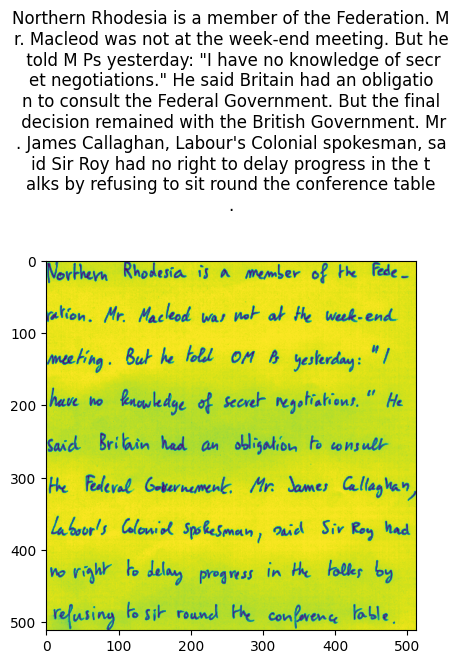

In [8]:
plt.imshow(x_train[0])
t = "".join([characters[_] for _ in y_true[0] if _<len(characters)])
t = "".join([t[50*i:50*(i+1)]+"\n" for i in range((len(t)+100)//50)])
plt.title(t)
plt.show()

In [9]:
def create_recognition_model(img_size, labels_len):               
    x = x_input = tf.keras.layers.Input(shape=(*img_size, 1), name='x_input')
        
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    
    x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)        
        
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    
    x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)                    
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)        
    
    x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)            
    
    # ----- LSTM -----        
    x = tf.keras.layers.Reshape((-1, 256))(x)          
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)    
    
    x = tf.keras.layers.Reshape((1024, 1, -1))(x)
    x = tf.keras.layers.Conv2D(labels_len, kernel_size=(1,1))(x)        
    x = tf.keras.layers.Reshape((-1, labels_len))(x)
    x = tf.keras.layers.Softmax()(x)                
    
    return tf.keras.models.Model(x_input, x)    

In [29]:
recognition_model = create_recognition_model(IMG_SIZE, len(characters)+1)
recognition_model.summary(110)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)                           │ (None, 512, 512, 1)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_14 (Conv2D)                             │ (None, 512, 512, 64)                │               1,664 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ leaky_re_lu_12 (LeakyReLU)                     │ (None, 512, 512, 64)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ max_pooling2d_12 (MaxPooling2D)                │ (None, 256, 256, 64)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_15 (Conv2D)                             │ (None, 256, 256, 128)               │             204,928 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ leaky_re_lu_13 (LeakyReLU)                     │ (None, 256, 256, 128)               │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ max_pooling2d_13 (MaxPooling2D)                │ (None, 128, 256, 128)               │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_16 (Conv2D)                             │ (None, 128, 256, 128)               │             147,584 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ leaky_re_lu_14 (LeakyReLU)                     │ (None, 128, 256, 128)               │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ max_pooling2d_14 (MaxPooling2D)                │ (None, 64, 128, 128)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_17 (Conv2D)                             │ (None, 64, 128, 256)                │             295,168 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ leaky_re_lu_15 (LeakyReLU)                     │ (None, 64, 128, 256)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ max_pooling2d_15 (MaxPooling2D)                │ (None, 32, 64, 256)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv2d_18 (Conv2D)                             │ (None, 32, 64, 512)                 │           1,180,160 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ batch_normalization_2 (BatchNormalization)     │ (None, 32, 64, 512)                 │               2,048 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ leaky_re_lu_16 (LeakyReLU)                     │ (None, 32, 64, 512)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ max_pooling2d_16 (MaxPooling2D)                │ (None, 16, 64, 512)                 │                   0 │
├───

 Total params: 4,606,674 (17.57 MB)

 Trainable params: 4,605,650 (17.57 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [11]:
logit_len = np.full((x_train.shape[0], 1), recognition_model.outputs[0].shape[1])
"Tensor shape:", logit_len.shape, "Timestamps length:", logit_len[0][0]

('Tensor shape:', (958, 1), 'Timestamps length:', 1024)

In [12]:
y_true_categorical = tf.keras.utils.to_categorical(y_true)
y_true_categorical.shape

(958, 1024, 82)

In [13]:
def create_train_model(model):
    x_input = tf.keras.layers.Input(shape=model.inputs[0].shape[1:], name='img')
    y_true = tf.keras.layers.Input(shape=(SEQ_LEN,), name='y_true')
    label_len = tf.keras.layers.Input(shape=(1,), name="label_len")    
    logits_len = tf.keras.layers.Input(shape=(1,), name="logits_len")      
    
    y_pred = model(x_input)       
    
    def ctc_layer(data):        
        y_true, y_pred, logit_len, label_len = data               
        return tf.keras.backend.ctc_batch_cost(y_true, y_pred, logit_len, label_len)

    ctc_out = tf.keras.layers.Lambda(ctc_layer, name="ctc")([y_true, y_pred, logits_len, label_len]) 
    
    pred_out = tf.keras.layers.Lambda(lambda x:x, name="pred")(y_pred)
    true_out = tf.keras.layers.Lambda(lambda x:x, name="true")(y_true)
    
    return tf.keras.models.Model([x_input, y_true, label_len, logits_len], [ctc_out, pred_out])    


In [30]:
train_model = create_train_model(recognition_model)

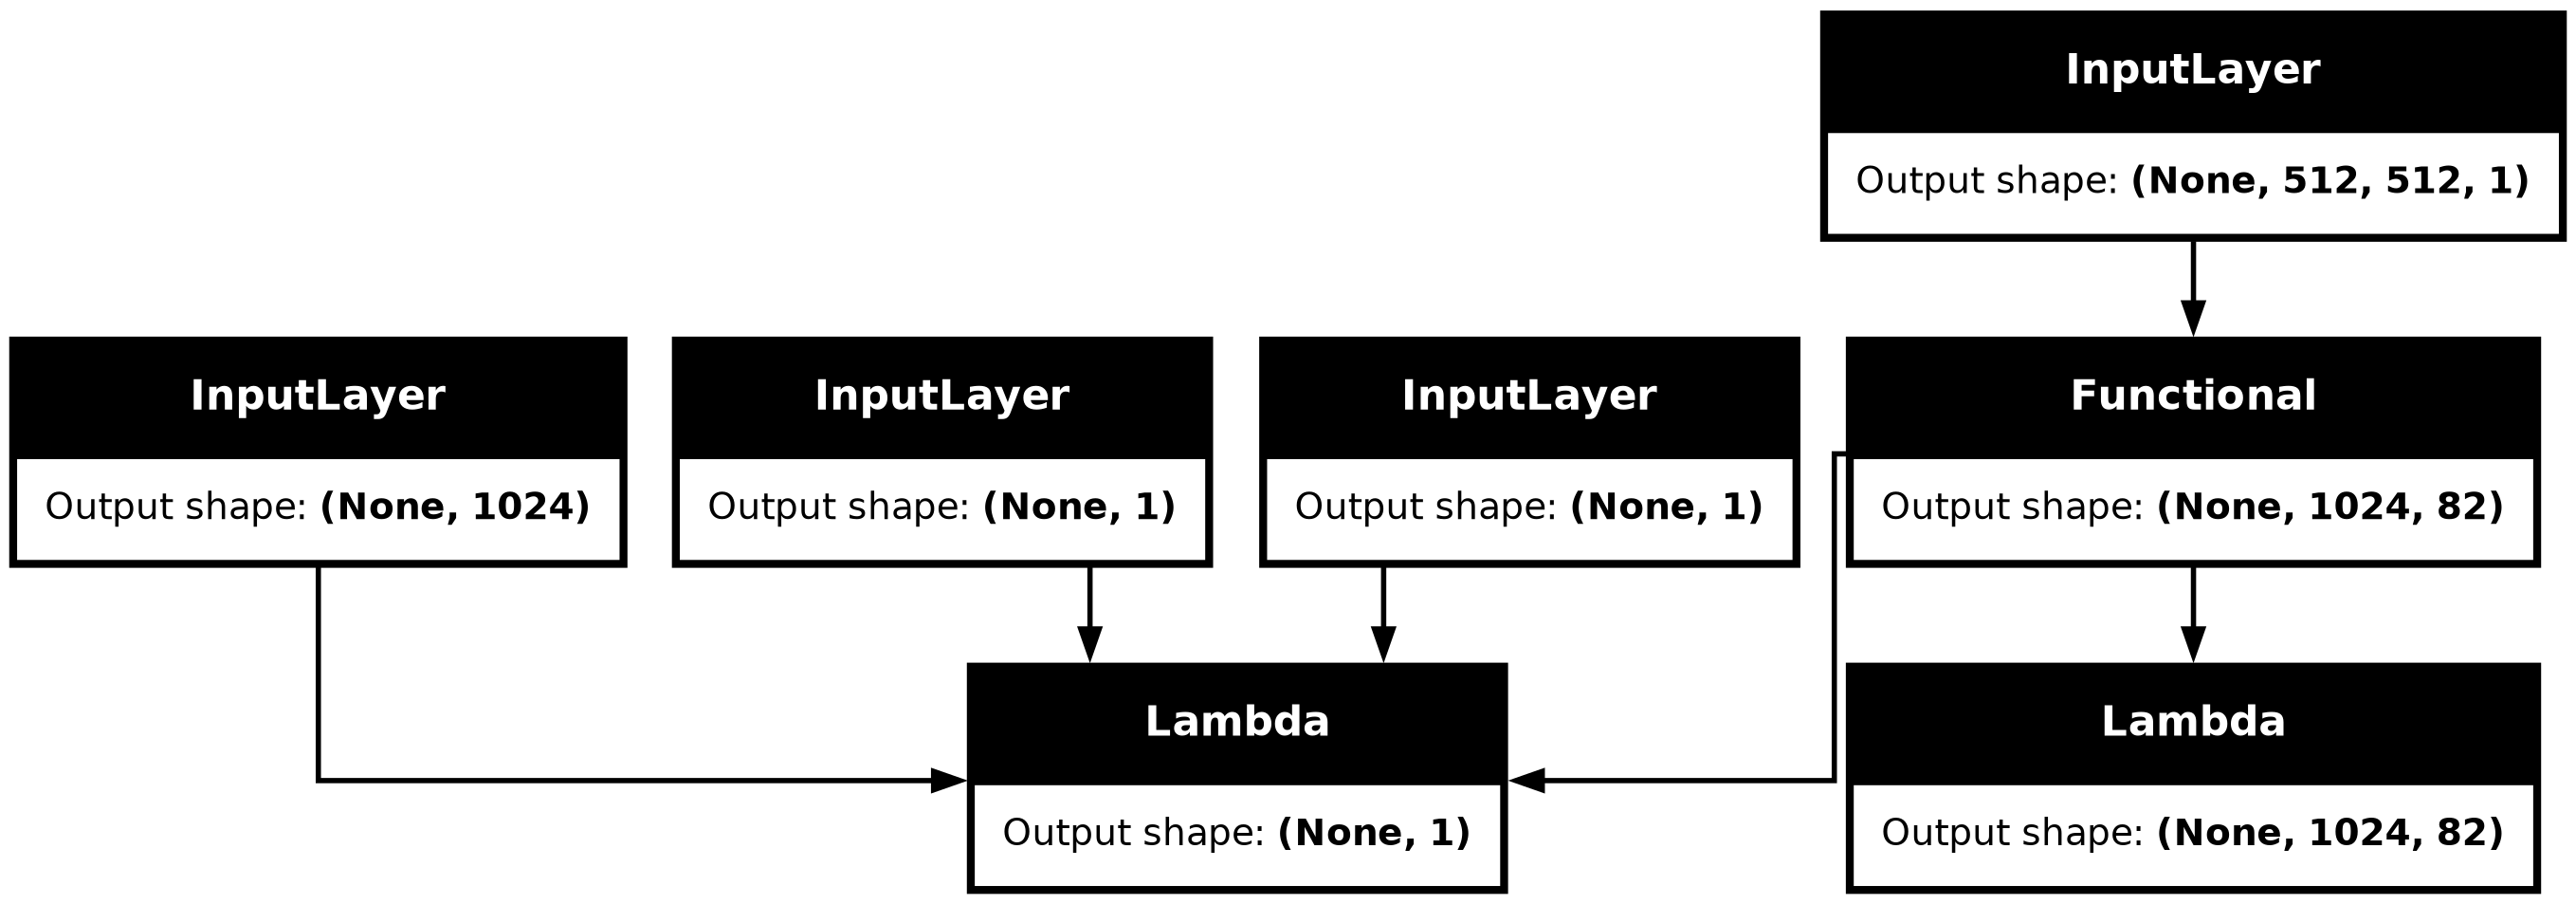

In [24]:
tf.keras.utils.plot_model(train_model, expand_nested=False, show_shapes=True)

In [16]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_input_shape = tf.keras.backend.shape(y_pred)
        pred_input_length = tf.ones(shape=pred_input_shape[0]) * tf.keras.backend.cast(pred_input_shape[1], 'float32')
        true_input_shape = tf.keras.backend.shape(y_true)
        true_input_length = tf.ones(shape=true_input_shape[0]) * tf.keras.backend.cast(true_input_shape[1], 'float32')                           
                
        pred, _ = tf.keras.backend.ctc_decode(y_pred, pred_input_length, greedy=True)                
        true, _ = tf.keras.backend.ctc_decode(y_true, true_input_length, greedy=True)        
        
        pred, true = pred[0], true[0]        
        
        pred_length = tf.keras.backend.cast(tf.math.argmin(pred, axis=1), 'int32')
        true_length = tf.keras.backend.cast(tf.math.argmin(true, axis=1), 'int32')                    
        
        pred = tf.keras.backend.ctc_label_dense_to_sparse(pred, pred_length)
        true = tf.keras.backend.ctc_label_dense_to_sparse(true, true_length)
                           
        distance = tf.edit_distance(pred, true, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(tf.cast(pred_input_shape[0],'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

In [17]:
class WERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Word Error Rate
    """
    def __init__(self, name='WER_metric', **kwargs):
        super(WERMetric, self).__init__(name=name, **kwargs)
        self.wer_accumulator = self.add_weight(name="total_wer", initializer="zeros")
        self.counter = self.add_weight(name="wer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        pred_input_shape = tf.keras.backend.shape(y_pred)
        pred_input_length = tf.ones(shape=pred_input_shape[0]) * tf.keras.backend.cast(pred_input_shape[1], 'float32')
        true_input_shape = tf.keras.backend.shape(y_true)
        true_input_length = tf.ones(shape=true_input_shape[0]) * tf.keras.backend.cast(true_input_shape[1], 'float32')                           
                
        pred, _ = tf.keras.backend.ctc_decode(y_pred, pred_input_length, greedy=True)                
        true, _ = tf.keras.backend.ctc_decode(y_true, true_input_length, greedy=True)        
        
        pred, true = pred[0], true[0]        
        
        pred_length = tf.keras.backend.cast(tf.math.argmin(pred, axis=1), 'int32')
        true_length = tf.keras.backend.cast(tf.math.argmin(true, axis=1), 'int32')                    
        
        pred = tf.keras.backend.ctc_label_dense_to_sparse(pred, pred_length)
        true = tf.keras.backend.ctc_label_dense_to_sparse(true, true_length)
                           
        distance = tf.edit_distance(pred, true, normalize=True)
                
        red_y_true = tf.argmax(y_true, axis=2)        
        
        spaces_mask = tf.equal(red_y_true, tf.zeros((), dtype=tf.int64))
        spaces_count = tf.reduce_sum(tf.cast(spaces_mask, tf.int32), axis=1)        
                
        words_count = tf.add(spaces_count, tf.ones_like(spaces_count))        
        words_count = tf.reduce_sum(words_count)        

        self.wer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(tf.cast(words_count,'float32'))


    def result(self):
        return tf.math.divide_no_nan(self.wer_accumulator, self.counter)

    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

In [31]:
train_model.compile(optimizer="rmsprop", 
                    loss={
                        'ctc': lambda y_true, y_pred: y_pred                 
                    }, 
                    metrics={
                        'ctc':"accuracy",
                        'pred':[CERMetric(),WERMetric()]
                    })

In [28]:
def callback_plot(epoch, logs):    
    if epoch%5==0:    
        n=1
        in_img = x_train[:n,:,:,:]
        in_true = y_true[:n,:]
        out_pred = recognition_model.predict(in_img) #tf.math.argmax(recognition_model.predict(in_img), axis=2)                    

        for i in range(n):        
            img = in_img[i]
            true = in_true[i]
            true = "".join([characters[c] for c in true if c<len(characters)])
            true = true[:50]+"..."
            pred = out_pred[i]
            
        fig, axs = plt.subplots(2)
        fig.suptitle(true)        
        axs[0].imshow(img)                
        
        def label2char(l): 
            c = characters[l] if l<len(characters) else "ε"
            if c==" ": c="\\s"
            return c
        
        for i in range(len(characters)+1):
            yc = pred[:,i]
            im = np.argmax(yc)            
            axs[1].plot(yc)   
            plt.text(im, yc[im], label2char(i))            
        
        plt.show()
            

    if epoch%3==0:
        recognition_model.save_weights("model_lstm_fullscale.weights.h5")

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/stepstep - ctc_accuracy: 0.0000e+00 - loss: 1355.1501 - pred_CER_metric: 0.9972 - pred_WER_metric: 0.01


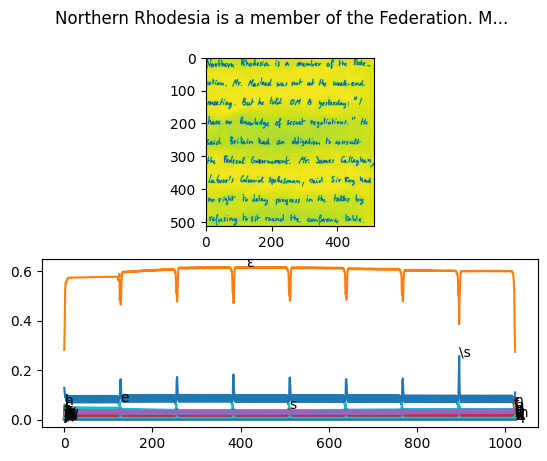

173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 428ms/step - ctc_accuracy: 0.0000e+00 - loss: 1354.4456 - pred_CER_metric: 0.9971 - pred_WER_metric: 0.0146 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1205.4595 - val_pred_CER_metric: 1.0000 - val_pred_WER_metric: 0.0153 - learning_rate: 0.0010
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 414ms/step - ctc_accuracy: 0.0000e+00 - loss: 1194.8025 - pred_CER_metric: 0.9237 - pred_WER_metric: 0.0135 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1177.1497 - val_pred_CER_metric: 0.8964 - val_pred_WER_metric: 0.0137 - learning_rate: 0.0010
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 411ms/step - ctc_accuracy: 0.0000e+00 - loss: 1159.1509 - pred_CER_metric: 0.8833 - pred_WER_metric: 0.0131 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1162.6693 - val_pred_CER_metric: 0.9095 - val_pred_WER_metric: 0.0139 - learning_rate: 0.0010
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 411ms/step - ctc_accuracy: 0.0000e+00 - loss: 1157.0168 - pred_CER_metric: 0.8638 - pred_WER_metr

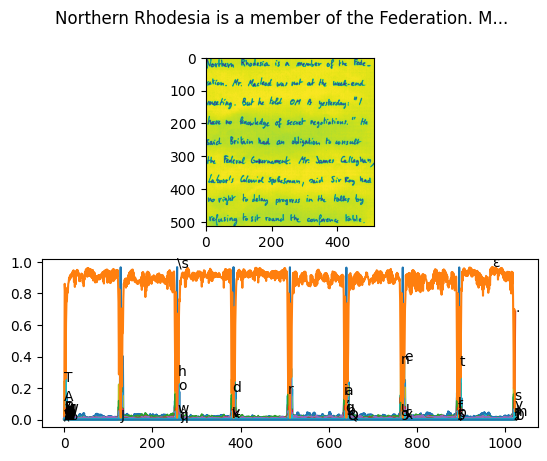

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 412ms/step - ctc_accuracy: 0.0000e+00 - loss: 1143.7646 - pred_CER_metric: 0.8642 - pred_WER_metric: 0.0128 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1411.7546 - val_pred_CER_metric: 0.9292 - val_pred_WER_metric: 0.0142 - learning_rate: 0.0010
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 408ms/step - ctc_accuracy: 0.0000e+00 - loss: 1143.2610 - pred_CER_metric: 0.8636 - pred_WER_metric: 0.0127 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1300.8402 - val_pred_CER_metric: 0.8560 - val_pred_WER_metric: 0.0131 - learning_rate: 0.0010
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 410ms/step - ctc_accuracy: 0.0000e+00 - loss: 1128.6409 - pred_CER_metric: 0.8595 - pred_WER_metric: 0.0127 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1147.0167 - val_pred_CER_metric: 0.8566 - val_pred_WER_metric: 0.0131 - learning_rate: 0.0010
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - ctc_accuracy: 0.0000e+00 - loss: 1136.3933 - pred_CER_metric: 0.8607 - pred_WER_metr

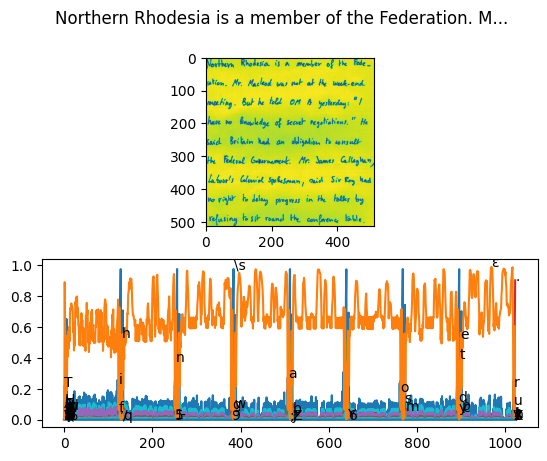

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 413ms/step - ctc_accuracy: 0.0000e+00 - loss: 1136.2733 - pred_CER_metric: 0.8598 - pred_WER_metric: 0.0127 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1176.6488 - val_pred_CER_metric: 0.8524 - val_pred_WER_metric: 0.0130 - learning_rate: 0.0010
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 408ms/step - ctc_accuracy: 0.0000e+00 - loss: 1126.1871 - pred_CER_metric: 0.8593 - pred_WER_metric: 0.0127 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1155.2938 - val_pred_CER_metric: 0.8576 - val_pred_WER_metric: 0.0131 - learning_rate: 0.0010
Epoch 13/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 411ms/step - ctc_accuracy: 0.0000e+00 - loss: 1139.3628 - pred_CER_metric: 0.8627 - pred_WER_metric: 0.0127 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1623.8397 - val_pred_CER_metric: 0.8736 - val_pred_WER_metric: 0.0134 - learning_rate: 0.0010
Epoch 14/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 409ms/step - ctc_accuracy: 0.0000e+00 - loss: 1118.1008 - pred_CER_metric: 0.8477 - pred_WER_m

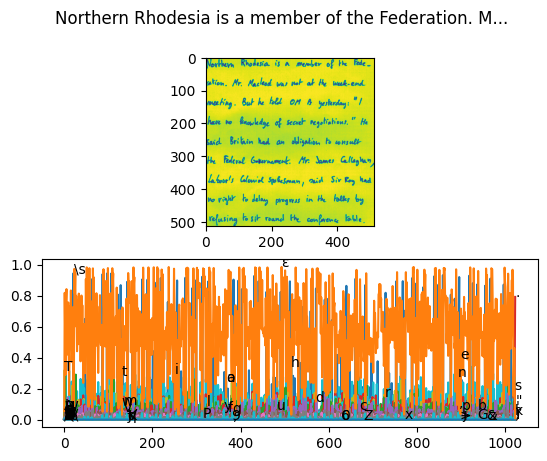

173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 415ms/step - ctc_accuracy: 0.0000e+00 - loss: 1071.2452 - pred_CER_metric: 0.7619 - pred_WER_metric: 0.0114 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1090.5721 - val_pred_CER_metric: 0.7400 - val_pred_WER_metric: 0.0113 - learning_rate: 0.0010
Epoch 17/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 409ms/step - ctc_accuracy: 0.0000e+00 - loss: 1056.1222 - pred_CER_metric: 0.7457 - pred_WER_metric: 0.0111 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1079.5668 - val_pred_CER_metric: 0.7077 - val_pred_WER_metric: 0.0108 - learning_rate: 0.0010
Epoch 18/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 406ms/step - ctc_accuracy: 0.0000e+00 - loss: 1013.2867 - pred_CER_metric: 0.7206 - pred_WER_metric: 0.0107 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1040.0867 - val_pred_CER_metric: 0.6861 - val_pred_WER_metric: 0.0105 - learning_rate: 0.0010
Epoch 19/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 408ms/step - ctc_accuracy: 0.0000e+00 - loss: 951.9158 - pred_CER_metric: 0.6769 - pred_WER_me

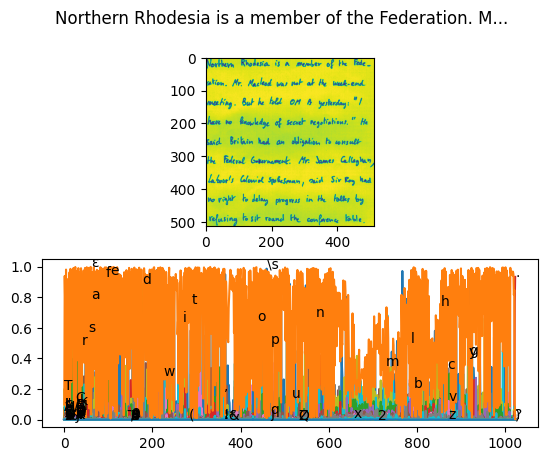

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 410ms/step - ctc_accuracy: 0.0000e+00 - loss: 859.9056 - pred_CER_metric: 0.5935 - pred_WER_metric: 0.0087 - val_ctc_accuracy: 0.0000e+00 - val_loss: 953.9279 - val_pred_CER_metric: 0.6207 - val_pred_WER_metric: 0.0095 - learning_rate: 0.0010
Epoch 22/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 406ms/step - ctc_accuracy: 0.0000e+00 - loss: 818.8412 - pred_CER_metric: 0.5426 - pred_WER_metric: 0.0079 - val_ctc_accuracy: 0.0000e+00 - val_loss: 863.8958 - val_pred_CER_metric: 0.5292 - val_pred_WER_metric: 0.0081 - learning_rate: 0.0010
Epoch 23/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 408ms/step - ctc_accuracy: 0.0000e+00 - loss: 727.1877 - pred_CER_metric: 0.4884 - pred_WER_metric: 0.0073 - val_ctc_accuracy: 0.0000e+00 - val_loss: 946.1749 - val_pred_CER_metric: 0.6231 - val_pred_WER_metric: 0.0095 - learning_rate: 0.0010
Epoch 24/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 409ms/step - ctc_accuracy: 0.0000e+00 - loss: 667.8631 - pred_CER_metric: 0.4408 - pred_WER_metric: 

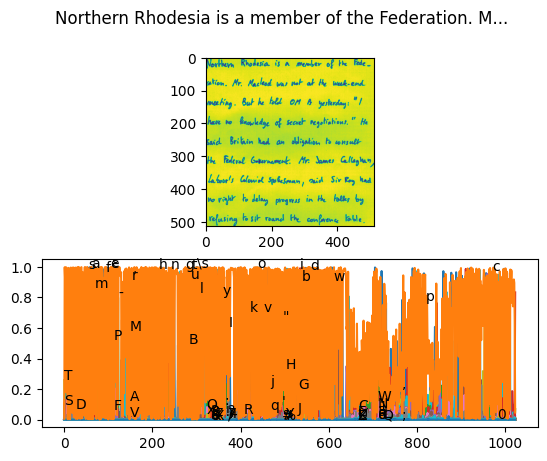

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 411ms/step - ctc_accuracy: 0.0000e+00 - loss: 603.7952 - pred_CER_metric: 0.3796 - pred_WER_metric: 0.0056 - val_ctc_accuracy: 0.0000e+00 - val_loss: 723.5143 - val_pred_CER_metric: 0.4180 - val_pred_WER_metric: 0.0064 - learning_rate: 0.0010
Epoch 27/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - ctc_accuracy: 0.0000e+00 - loss: 557.5656 - pred_CER_metric: 0.3512 - pred_WER_metric: 0.0052 - val_ctc_accuracy: 0.0000e+00 - val_loss: 760.5040 - val_pred_CER_metric: 0.4166 - val_pred_WER_metric: 0.0064 - learning_rate: 0.0010
Epoch 28/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 408ms/step - ctc_accuracy: 0.0000e+00 - loss: 537.8279 - pred_CER_metric: 0.3378 - pred_WER_metric: 0.0050 - val_ctc_accuracy: 0.0000e+00 - val_loss: 672.8259 - val_pred_CER_metric: 0.3499 - val_pred_WER_metric: 0.0054 - learning_rate: 0.0010
Epoch 29/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - ctc_accuracy: 0.0000e+00 - loss: 521.2667 - pred_CER_metric: 0.3147 - pred_WER_metric: 

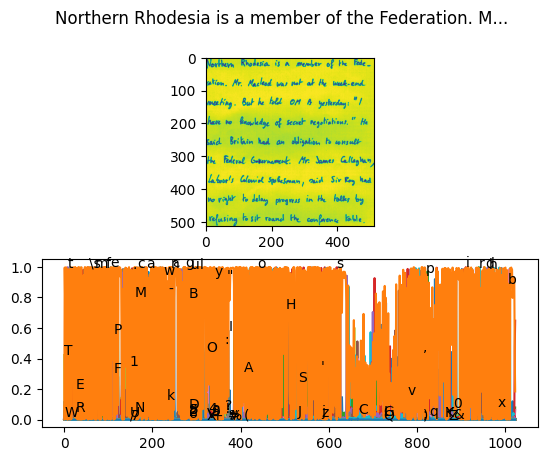

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 412ms/step - ctc_accuracy: 0.0000e+00 - loss: 444.8758 - pred_CER_metric: 0.2770 - pred_WER_metric: 0.0041 - val_ctc_accuracy: 0.0000e+00 - val_loss: 699.7372 - val_pred_CER_metric: 0.3859 - val_pred_WER_metric: 0.0059 - learning_rate: 0.0010
Epoch 32/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 408ms/step - ctc_accuracy: 0.0000e+00 - loss: 401.7697 - pred_CER_metric: 0.2572 - pred_WER_metric: 0.0039 - val_ctc_accuracy: 0.0000e+00 - val_loss: 651.2145 - val_pred_CER_metric: 0.3360 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 33/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 406ms/step - ctc_accuracy: 0.0000e+00 - loss: 414.5695 - pred_CER_metric: 0.2596 - pred_WER_metric: 0.0039 - val_ctc_accuracy: 0.0000e+00 - val_loss: 666.5867 - val_pred_CER_metric: 0.3296 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 34/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - ctc_accuracy: 0.0000e+00 - loss: 416.8486 - pred_CER_metric: 0.2536 - pred_WER_metric: 

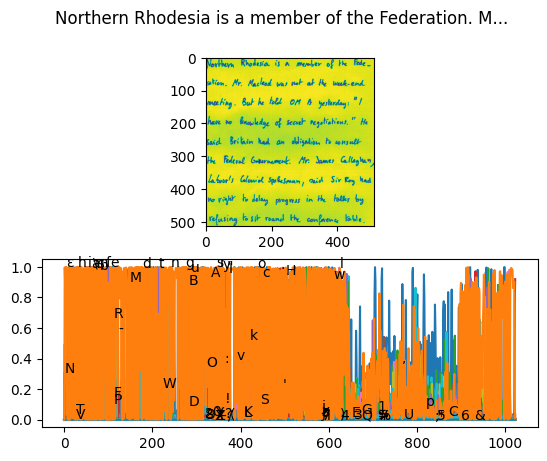

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 411ms/step - ctc_accuracy: 0.0000e+00 - loss: 381.1323 - pred_CER_metric: 0.2327 - pred_WER_metric: 0.0034 - val_ctc_accuracy: 0.0000e+00 - val_loss: 708.9457 - val_pred_CER_metric: 0.3861 - val_pred_WER_metric: 0.0059 - learning_rate: 0.0010
Epoch 37/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - ctc_accuracy: 0.0000e+00 - loss: 357.5666 - pred_CER_metric: 0.2233 - pred_WER_metric: 0.0033 - val_ctc_accuracy: 0.0000e+00 - val_loss: 722.1063 - val_pred_CER_metric: 0.3286 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 38/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 404ms/step - ctc_accuracy: 0.0000e+00 - loss: 310.7972 - pred_CER_metric: 0.2006 - pred_WER_metric: 0.0030 - val_ctc_accuracy: 0.0000e+00 - val_loss: 728.5807 - val_pred_CER_metric: 0.3118 - val_pred_WER_metric: 0.0048 - learning_rate: 0.0010
Epoch 39/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 400ms/step - ctc_accuracy: 0.0000e+00 - loss: 311.8573 - pred_CER_metric: 0.1992 - pred_WER_metric: 

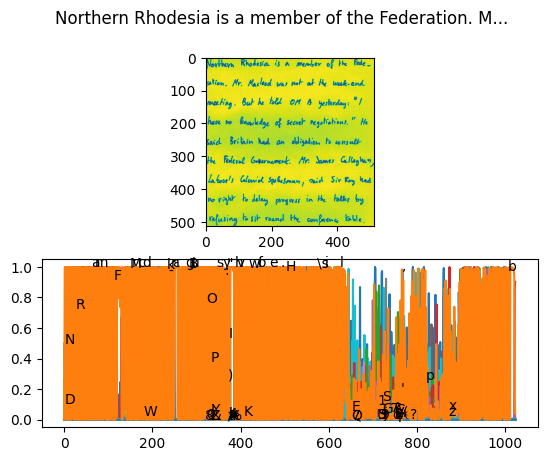

173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - ctc_accuracy: 0.0000e+00 - loss: 282.1876 - pred_CER_metric: 0.1873 - pred_WER_metric: 0.0028 - val_ctc_accuracy: 0.0000e+00 - val_loss: 733.8207 - val_pred_CER_metric: 0.3335 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 42/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 399ms/step - ctc_accuracy: 0.0000e+00 - loss: 250.8088 - pred_CER_metric: 0.1709 - pred_WER_metric: 0.0025 - val_ctc_accuracy: 0.0000e+00 - val_loss: 755.9386 - val_pred_CER_metric: 0.3175 - val_pred_WER_metric: 0.0049 - learning_rate: 0.0010
Epoch 43/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 399ms/step - ctc_accuracy: 0.0000e+00 - loss: 232.7784 - pred_CER_metric: 0.1598 - pred_WER_metric: 0.0024 - val_ctc_accuracy: 0.0000e+00 - val_loss: 787.3078 - val_pred_CER_metric: 0.3051 - val_pred_WER_metric: 0.0047 - learning_rate: 0.0010
Epoch 44/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 398ms/step - ctc_accuracy: 0.0000e+00 - loss: 216.8639 - pred_CER_metric: 0.1510 - pred_WER_metric: 

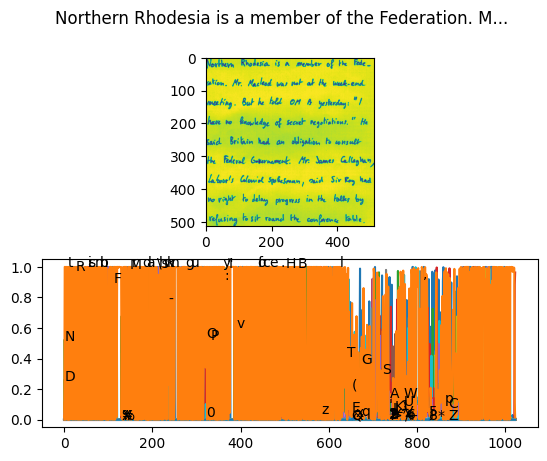

173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 403ms/step - ctc_accuracy: 0.0000e+00 - loss: 192.8130 - pred_CER_metric: 0.1383 - pred_WER_metric: 0.0020 - val_ctc_accuracy: 0.0000e+00 - val_loss: 860.9207 - val_pred_CER_metric: 0.3297 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 47/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 398ms/step - ctc_accuracy: 0.0000e+00 - loss: 167.8504 - pred_CER_metric: 0.1239 - pred_WER_metric: 0.0018 - val_ctc_accuracy: 0.0000e+00 - val_loss: 852.3307 - val_pred_CER_metric: 0.3281 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 48/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 397ms/step - ctc_accuracy: 0.0000e+00 - loss: 149.6962 - pred_CER_metric: 0.1121 - pred_WER_metric: 0.0017 - val_ctc_accuracy: 0.0000e+00 - val_loss: 852.9647 - val_pred_CER_metric: 0.3118 - val_pred_WER_metric: 0.0048 - learning_rate: 0.0010
Epoch 49/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 397ms/step - ctc_accuracy: 0.0000e+00 - loss: 144.2058 - pred_CER_metric: 0.1088 - pred_WER_metric: 

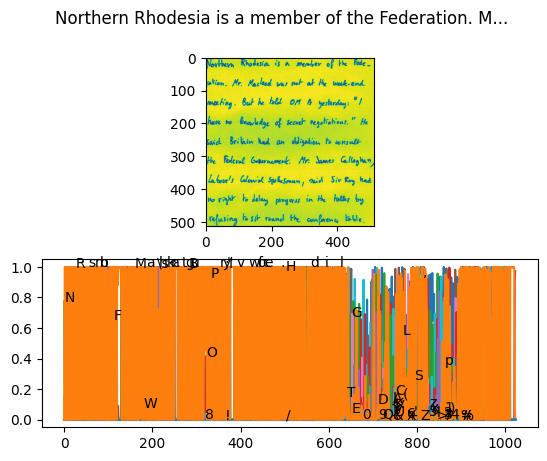

173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 406ms/step - ctc_accuracy: 0.0000e+00 - loss: 121.6723 - pred_CER_metric: 0.0917 - pred_WER_metric: 0.0014 - val_ctc_accuracy: 0.0000e+00 - val_loss: 953.7448 - val_pred_CER_metric: 0.3900 - val_pred_WER_metric: 0.0060 - learning_rate: 0.0010
Epoch 52/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 398ms/step - ctc_accuracy: 0.0000e+00 - loss: 107.0792 - pred_CER_metric: 0.0841 - pred_WER_metric: 0.0013 - val_ctc_accuracy: 0.0000e+00 - val_loss: 927.1530 - val_pred_CER_metric: 0.3451 - val_pred_WER_metric: 0.0053 - learning_rate: 0.0010
Epoch 53/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 397ms/step - ctc_accuracy: 0.0000e+00 - loss: 98.3736 - pred_CER_metric: 0.0781 - pred_WER_metric: 0.0011 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1086.6533 - val_pred_CER_metric: 0.3295 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 54/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 68s 396ms/step - ctc_accuracy: 0.0000e+00 - loss: 98.6734 - pred_CER_metric: 0.0779 - pred_WER_metric: 0

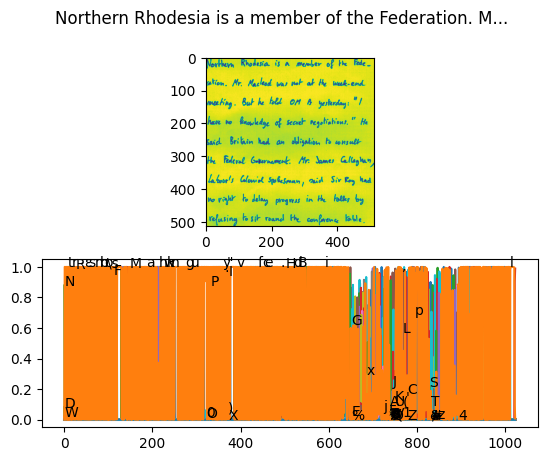

173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 403ms/step - ctc_accuracy: 0.0000e+00 - loss: 63.3461 - pred_CER_metric: 0.0569 - pred_WER_metric: 8.4323e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1051.7316 - val_pred_CER_metric: 0.3313 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 57/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 398ms/step - ctc_accuracy: 0.0000e+00 - loss: 60.1401 - pred_CER_metric: 0.0545 - pred_WER_metric: 8.0999e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1081.0348 - val_pred_CER_metric: 0.3238 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 58/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 399ms/step - ctc_accuracy: 0.0000e+00 - loss: 56.5564 - pred_CER_metric: 0.0514 - pred_WER_metric: 7.5858e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1067.4670 - val_pred_CER_metric: 0.3393 - val_pred_WER_metric: 0.0052 - learning_rate: 0.0010
Epoch 59/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 400ms/step - ctc_accuracy: 0.0000e+00 - loss: 46.2702 - pred_CER_metric: 0.0445 - pred_W

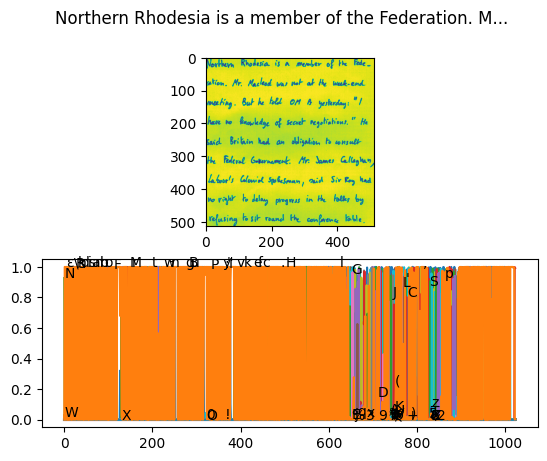

173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 404ms/step - ctc_accuracy: 0.0000e+00 - loss: 39.6902 - pred_CER_metric: 0.0403 - pred_WER_metric: 5.8843e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1126.1821 - val_pred_CER_metric: 0.3249 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 62/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 399ms/step - ctc_accuracy: 0.0000e+00 - loss: 37.6054 - pred_CER_metric: 0.0399 - pred_WER_metric: 5.9535e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1166.3783 - val_pred_CER_metric: 0.3281 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 63/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 400ms/step - ctc_accuracy: 0.0000e+00 - loss: 41.5037 - pred_CER_metric: 0.0420 - pred_WER_metric: 6.2284e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1152.9729 - val_pred_CER_metric: 0.3319 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 64/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 411ms/step - ctc_accuracy: 0.0058 - loss: 34.2486 - pred_CER_metric: 0.0413 - pred_WER_m

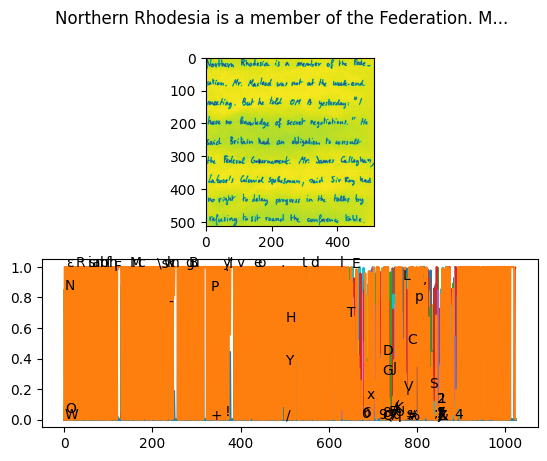

173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 415ms/step - ctc_accuracy: 6.8098e-04 - loss: 32.0497 - pred_CER_metric: 0.0367 - pred_WER_metric: 5.3361e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1360.7717 - val_pred_CER_metric: 0.3663 - val_pred_WER_metric: 0.0056 - learning_rate: 0.0010
Epoch 67/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 412ms/step - ctc_accuracy: 0.0044 - loss: 38.8498 - pred_CER_metric: 0.0407 - pred_WER_metric: 5.9012e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1197.1907 - val_pred_CER_metric: 0.3575 - val_pred_WER_metric: 0.0055 - learning_rate: 0.0010
Epoch 68/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 414ms/step - ctc_accuracy: 1.6254e-04 - loss: 27.1703 - pred_CER_metric: 0.0346 - pred_WER_metric: 5.0888e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1193.8503 - val_pred_CER_metric: 0.3274 - val_pred_WER_metric: 0.0050 - learning_rate: 0.0010
Epoch 69/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 410ms/step - ctc_accuracy: 0.0000e+00 - loss: 23.6560 - pred_CER_metric: 0.0330 - pred_WER_m

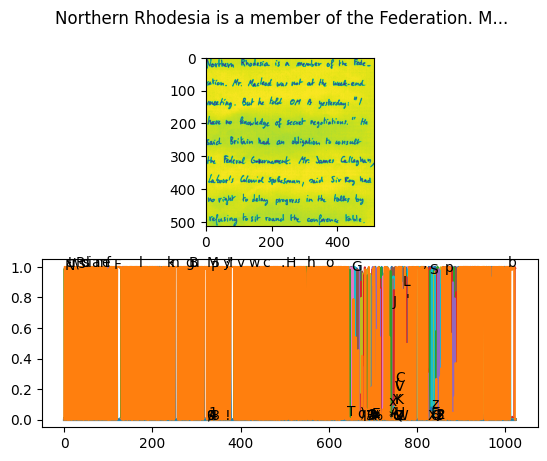

173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 416ms/step - ctc_accuracy: 0.0017 - loss: 26.2823 - pred_CER_metric: 0.0342 - pred_WER_metric: 5.0361e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1235.9990 - val_pred_CER_metric: 0.3432 - val_pred_WER_metric: 0.0053 - learning_rate: 0.0010
Epoch 72/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 412ms/step - ctc_accuracy: 0.0016 - loss: 21.7539 - pred_CER_metric: 0.0332 - pred_WER_metric: 4.9600e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1227.2539 - val_pred_CER_metric: 0.3374 - val_pred_WER_metric: 0.0052 - learning_rate: 0.0010
Epoch 73/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 412ms/step - ctc_accuracy: 7.4213e-04 - loss: 19.2852 - pred_CER_metric: 0.0308 - pred_WER_metric: 4.5624e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1224.3093 - val_pred_CER_metric: 0.3747 - val_pred_WER_metric: 0.0057 - learning_rate: 0.0010
Epoch 74/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 410ms/step - ctc_accuracy: 0.0059 - loss: 25.5358 - pred_CER_metric: 0.0341 - pred_WER_metric: 4

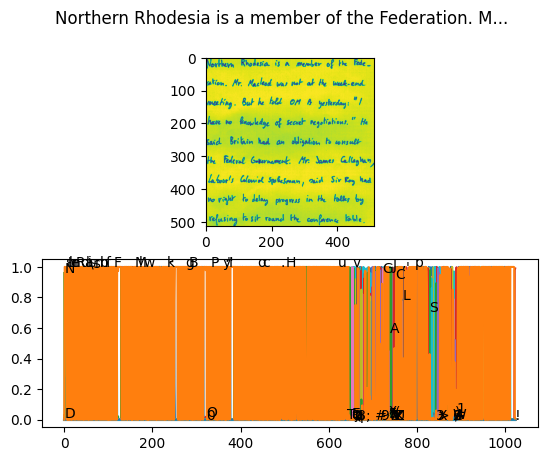

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 413ms/step - ctc_accuracy: 0.0030 - loss: 27.0062 - pred_CER_metric: 0.0381 - pred_WER_metric: 5.7034e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1301.6165 - val_pred_CER_metric: 0.3364 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 77/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - ctc_accuracy: 0.0073 - loss: 19.2866 - pred_CER_metric: 0.0314 - pred_WER_metric: 4.6350e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1289.1750 - val_pred_CER_metric: 0.3343 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 78/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 406ms/step - ctc_accuracy: 0.0025 - loss: 16.6679 - pred_CER_metric: 0.0296 - pred_WER_metric: 4.4190e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1316.1628 - val_pred_CER_metric: 0.3897 - val_pred_WER_metric: 0.0060 - learning_rate: 0.0010
Epoch 79/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 406ms/step - ctc_accuracy: 0.0055 - loss: 17.3148 - pred_CER_metric: 0.0304 - pred_WER_metric: 4.473

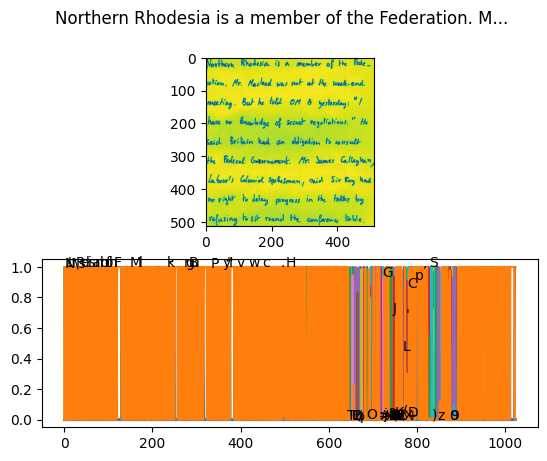

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 409ms/step - ctc_accuracy: 0.0064 - loss: 19.3258 - pred_CER_metric: 0.0305 - pred_WER_metric: 4.4999e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1281.6514 - val_pred_CER_metric: 0.3374 - val_pred_WER_metric: 0.0052 - learning_rate: 0.0010
Epoch 82/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 402ms/step - ctc_accuracy: 0.0169 - loss: 13.2341 - pred_CER_metric: 0.0275 - pred_WER_metric: 4.1205e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1375.9822 - val_pred_CER_metric: 0.3444 - val_pred_WER_metric: 0.0053 - learning_rate: 0.0010
Epoch 83/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 403ms/step - ctc_accuracy: 0.0073 - loss: 13.6776 - pred_CER_metric: 0.0277 - pred_WER_metric: 4.0809e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1384.9360 - val_pred_CER_metric: 0.3628 - val_pred_WER_metric: 0.0056 - learning_rate: 0.0010
Epoch 84/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 404ms/step - ctc_accuracy: 0.0102 - loss: 15.8024 - pred_CER_metric: 0.0291 - pred_WER_metric: 4.297

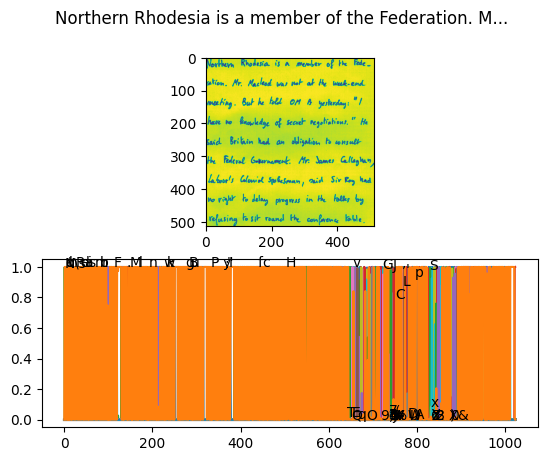

173/173 ━━━━━━━━━━━━━━━━━━━━ 83s 408ms/step - ctc_accuracy: 0.0124 - loss: 14.4155 - pred_CER_metric: 0.0276 - pred_WER_metric: 4.0489e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1347.4098 - val_pred_CER_metric: 0.3401 - val_pred_WER_metric: 0.0052 - learning_rate: 0.0010
Epoch 87/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 404ms/step - ctc_accuracy: 0.0071 - loss: 14.3504 - pred_CER_metric: 0.0283 - pred_WER_metric: 4.1985e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1357.3047 - val_pred_CER_metric: 0.3305 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 88/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 405ms/step - ctc_accuracy: 0.0078 - loss: 13.5035 - pred_CER_metric: 0.0281 - pred_WER_metric: 4.1945e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1388.5867 - val_pred_CER_metric: 0.3317 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 89/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 402ms/step - ctc_accuracy: 0.0185 - loss: 13.4659 - pred_CER_metric: 0.0274 - pred_WER_metric: 4.014

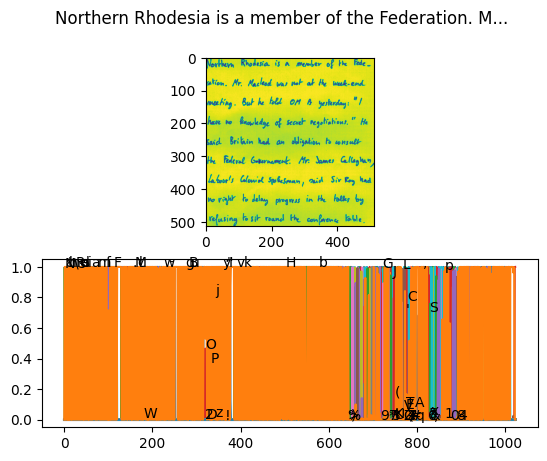

173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 408ms/step - ctc_accuracy: 0.0139 - loss: 11.4929 - pred_CER_metric: 0.0265 - pred_WER_metric: 3.9397e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1348.6542 - val_pred_CER_metric: 0.3454 - val_pred_WER_metric: 0.0053 - learning_rate: 0.0010
Epoch 92/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 81s 405ms/step - ctc_accuracy: 0.0179 - loss: 13.0779 - pred_CER_metric: 0.0268 - pred_WER_metric: 3.9509e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1415.9712 - val_pred_CER_metric: 0.3353 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 93/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 404ms/step - ctc_accuracy: 0.0133 - loss: 11.8487 - pred_CER_metric: 0.0264 - pred_WER_metric: 3.8948e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1383.0560 - val_pred_CER_metric: 0.3338 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 94/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 405ms/step - ctc_accuracy: 0.0147 - loss: 11.5207 - pred_CER_metric: 0.0261 - pred_WER_metric: 3.820

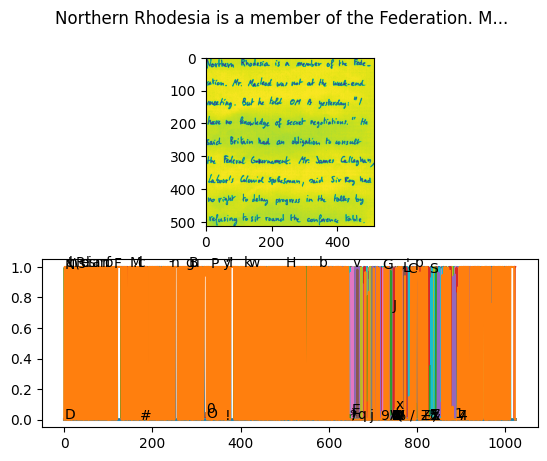

173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - ctc_accuracy: 0.0223 - loss: 11.3457 - pred_CER_metric: 0.0262 - pred_WER_metric: 3.8974e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1401.0551 - val_pred_CER_metric: 0.3340 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 97/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 401ms/step - ctc_accuracy: 0.0128 - loss: 11.7402 - pred_CER_metric: 0.0265 - pred_WER_metric: 3.8653e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1439.4700 - val_pred_CER_metric: 0.3347 - val_pred_WER_metric: 0.0051 - learning_rate: 0.0010
Epoch 98/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 403ms/step - ctc_accuracy: 0.0217 - loss: 10.3412 - pred_CER_metric: 0.0252 - pred_WER_metric: 3.7271e-04 - val_ctc_accuracy: 0.0000e+00 - val_loss: 1414.2687 - val_pred_CER_metric: 0.3559 - val_pred_WER_metric: 0.0054 - learning_rate: 0.0010
Epoch 99/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 70s 403ms/step - ctc_accuracy: 0.0156 - loss: 9.9697 - pred_CER_metric: 0.0256 - pred_WER_metric: 3.7666

In [32]:
lim=None
history = train_model.fit([x_train[:lim], y_true[:lim], y_len[:lim], logit_len[:lim]], [y_train[:lim], y_true_categorical[:lim]], 
                          validation_split=0.1, 
                          shuffle=True, 
                          epochs=100,
                          batch_size=5,
                          callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.6, patience=3, min_lr=0.001, mode="min", verbose=1),
    tf.keras.callbacks.LambdaCallback(on_epoch_end=callback_plot)
])

In [33]:
def plot_metric(metric_name):
    plt.plot(history.history[metric_name], label=metric_name)
    plt.plot(history.history[f'val_{metric_name}'], label=f"val_{metric_name}")
    plt.legend()
    plt.show()

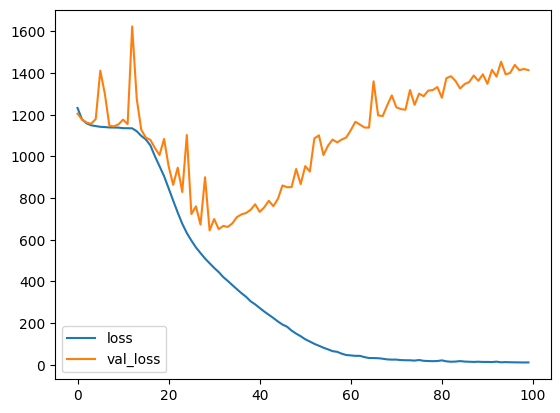

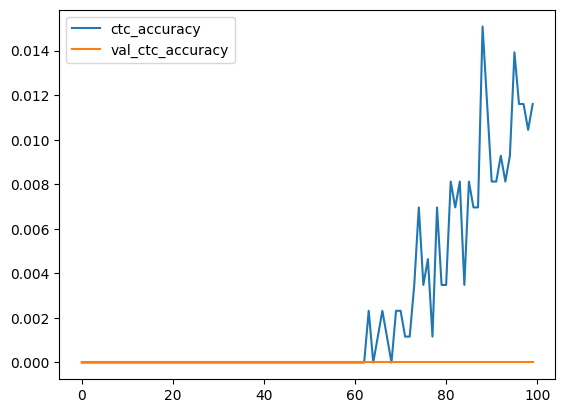

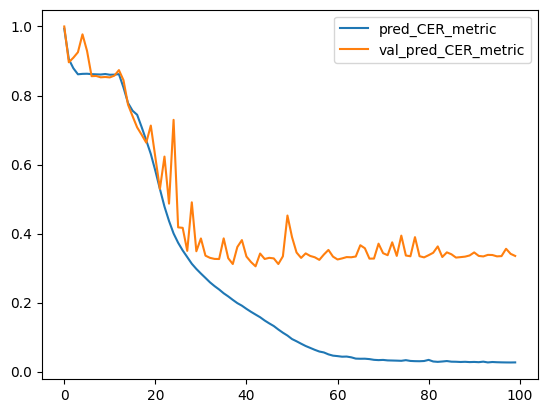

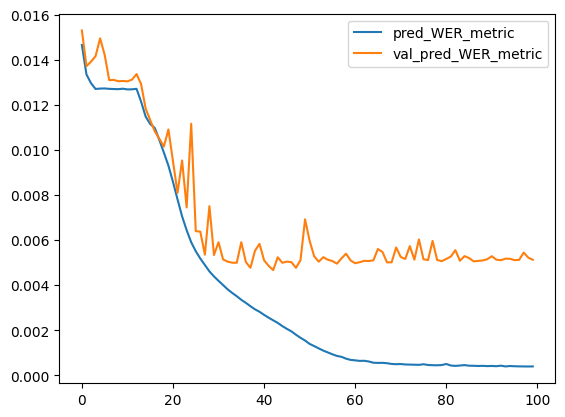

In [40]:
plot_metric("loss")
plot_metric("ctc_accuracy")
plot_metric("pred_CER_metric")
plot_metric("pred_WER_metric")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted:  Northern Rhodesia is a member of the Federation. Mr. Macleod was not at the week-end meeting. But he told M Ps yesterday: "I have no knowledge of secvet negotiations." He said Britain had an obligation to cnsult the Federal Government. But the final decision remained with the British Government. Mr. James lallaghan, abour's Colonial spokesman, said Sir Roy had no right to delay progress in the talks by refusing to sit round the conference table.


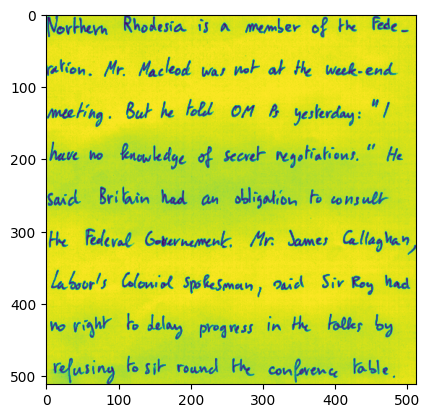

Predicted:  He was announcing his executive's rejection of the ultimatum to the ETU. In reply to the call for his resignation he said: "Our rules say that if an official resigns he is not allowed to run again for three years. "I have only 2 1/2 years to go before I retire, so this is an invitation from my good friends of the TUC that I should commit hara-kiri.


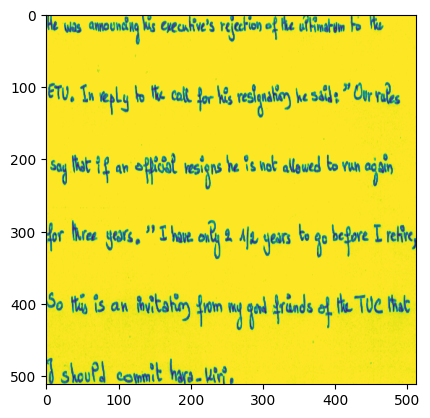

Predicted:  Te most convenient one for the authors has been the text of A. Souter. In this version of the text the Fourth Gospel is printed as just over 1,000 different nouns, verbs, and other parts of speech occurring 15,695 times in their different grammatical forms. There are other texts which could have been used, and (as shown in Table 1) it is not a matter of the greatest importance which text is used.


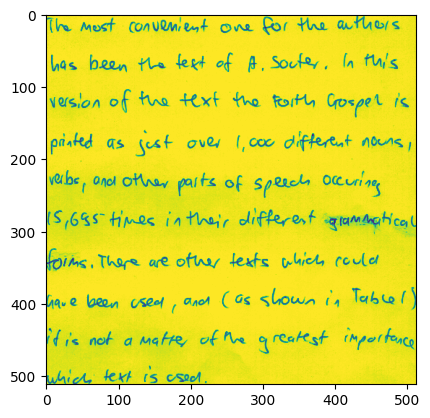

Predicted:  Was it his imagination or was the panel slightly lop-sided? Leaping forward with a choked sound he grasped the oblong panel and pulled it out. The black tin box was exactly as he had left it. With heavily beating heart he reached out and lifted the lid. Everything was intact and he gasped with relief.


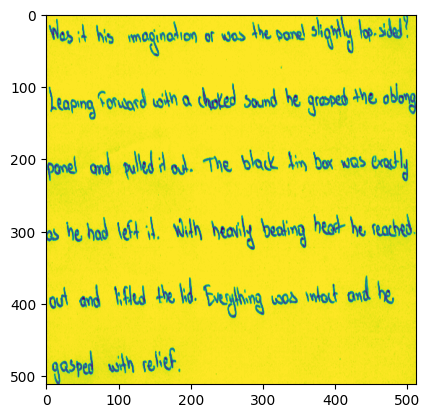

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted:  Sn no other conouered con trey, nof eten poland, had he germaS toy with sud aots rsic e. here  No odouis cpgamy we Jes corsmpteir of Eicota IoMiR he ad fereme peopte have a alas wevutts ta sk. But they do not matre thenselves less dislikod by ther f atthude to therk custommes - who ncadetaallg pay ther alare.


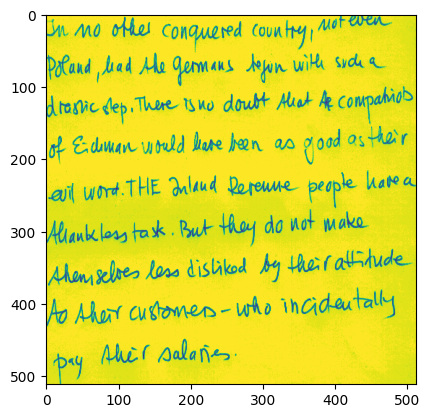

Predicted:  Whe was engaged to Nogel had been for to yeears. Loedins they takked an he theme of '"when we ger mavied', and then all was wondefue, and peraps it tad only beeen a ep of the torgue when Niger had said, ony ast verang, "II we or maried, ad gel, youitl hae to ot.p thal lak, I can tel gu!


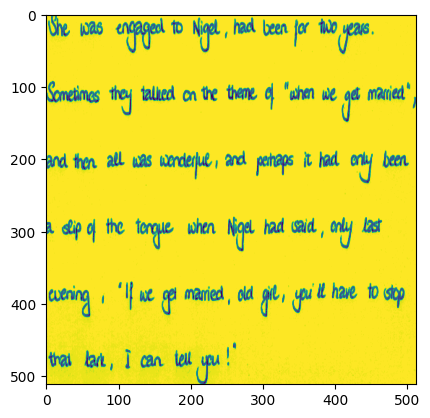

Predicted:  Fot withut the ision to serve the Lord youc God with al yout heat and with all you saul oud with all yarur iggt he poblem o lire aunt be soned. "Therfoce shall ye lay on these ny woods in yyour heact ond in you sout. " Sme test adds andin your s an, saching you soul.


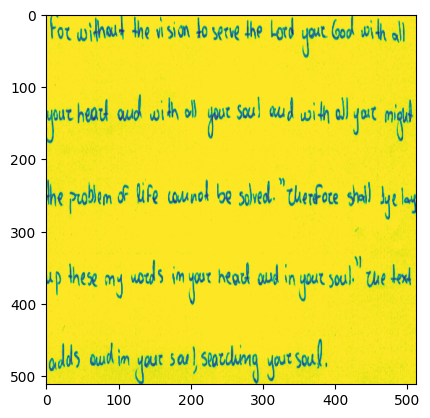

Predicted:  Ade did vell, Nleget vistauh withthe wo taunid hekors ote hatwheminen t alt ti uvin har io apedom eda. wln t Nel lepn e st tot  tle we oul Mosnehd erpll hatouwn Shee br rop,pe ecesan le herp we h ofbe ol tfpl red b decans  mif h. mhhn hin fhatogsly how. lie duwad eawb to emuru pohit paMean htla to aher ves h tivawiten whul ahotes om nsnd  mM oMek hr rargase, GiraDpweam t ssel peociol Grsn oc crien.


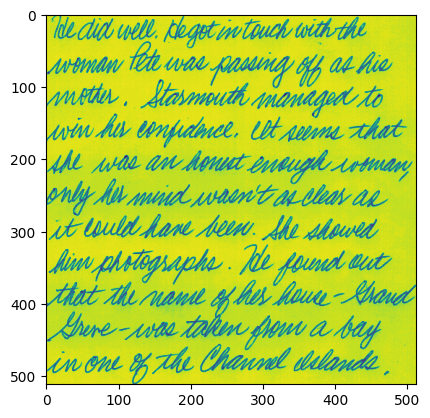

In [41]:
# recognition_model.load_weights('/kaggle/working/model_lstm_fullscale.h5')
def preview_output(x, yt, title):
    y = recognition_model.predict(x)
    seq_length = recognition_model.output.shape[1]    
    y, _ = tf.keras.backend.ctc_decode(y, np.array([seq_length]*y.shape[0]), greedy=True)
    y=y[0].numpy()        
    n = x.shape[0]    

    for i in range(n):                
        real_text = "".join([characters[c] for c in y[i] if 0<=c<len(characters)])               
        print("Predicted: ", real_text)
        plt.imshow(x[i])
        plt.show()
    plt.show()
    
preview_output(x_train[:4], y_true[:4], "Train snapshot")
preview_output(x_train[900:904], y_true[900:904], "Test snapshot")
